In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import os
import re
import pickle
from timeit import default_timer as timer
import sklearn
from sklearn.preprocessing import scale
from sklearn.manifold import Isomap, TSNE
from sklearn.metrics import silhouette_samples, silhouette_score
import scipy
import scipy.cluster.hierarchy
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import umap
import seaborn as sns
import matplotlib.cm as cm
import random

from matplotlib.backends.backend_pdf import PdfPages
from scipy.stats import mannwhitneyu

# from pysankey import sankey

from sklearn.cluster import AgglomerativeClustering, KMeans, DBSCAN, SpectralClustering, Birch
from sklearn.neighbors import NearestNeighbors
from sklearn.feature_selection import mutual_info_classif
from sklearn import metrics
import igraph
from math import ceil
from timeit import default_timer as timer
import subprocess
from pathlib import Path
from numpy import linalg as LA

import neuro_morpho_toolbox as nmt
from neuro_morpho_toolbox.ml_utilities import *
from neuro_morpho_toolbox.plot import qualitative_scatter

import SimpleITK as sitk

from ipywidgets import interactive
import ipywidgets as widgets

import plotly.plotly as py
import plotly.offline as po
import plotly.graph_objs as go

po.init_notebook_mode(connected=True)

import colorlover as cl
from IPython.display import HTML

bs_child_to_parent = {}

for pid in nmt.bs.selected_regions:
    pname = nmt.bs.level.loc[pid, "Abbrevation"]
    cname = [nmt.bs.level.loc[i, "Abbrevation"] for i in nmt.bs.get_all_child_id(pid)]
    for i in cname:
        bs_child_to_parent[i] = pname
bs_child_to_parent["unknown"] = "unknown"

/Users/pengxie/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


/Users/pengxie/Documents/Research/python/neuro_morhpo_toolbox/neuro_morpho_toolbox/
Loading CCF Atlas data...
Loading time: 0.84
Loading CCF brain structure data...
Loading time: 0.01


/Users/pengxie/.local/lib/python3.6/site-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


## Load data

In [2]:
[soma] = pickle.load(open("features_soma.pickle", "rb"))
[projection] = pickle.load(open("features_projection.pickle", "rb"))
[lm_axon] = pickle.load(open("features_lm_axon.pickle", "rb"))
[lm_dendrite] = pickle.load(open("features_lm_dendrite.pickle", "rb"))

In [3]:
# metadata, To be implemented 
cell_list = soma.neuron_list()
# metadata = soma.region.copy().loc[cell_list]
[metadata] = pickle.load(open("metadata.pickle", 'rb'))
metadata = metadata.loc[cell_list]
metadata['Brain_id'] = ['Brain_'+i.split("_")[0] for i in cell_list]
metadata['SWC'] = ['../Data/swc/mapped/Data_for_analysis/swc/Whole/'+i+'.swc' for i in cell_list]
# metadata['Celltype'] = 'UnAssigned'
# metadata['Subtype'] = 'UnAssigned'

[celltype_color_dict] = pickle.load(open("colors.pickle", "rb"))

In [4]:
projection_df = projection.scaled_data.copy() - np.log(100)
projection_df = projection_df.round(2)
use_features = projection_df.columns[np.sum(projection_df>0)>=3]
projection_df = projection_df[use_features]
print("Projection features: %d" % (projection_df.shape[1]))

Projection features: 82


In [5]:
soma_df = soma.raw_data.copy()

In [6]:
lm_axon_df = lm_axon.raw_data.copy()
use_cols = ['A_Overall_Width', 
            'A_Overall_Height', 
            'A_Overall_Depth', 
            'A_Total_Length', 
            'A_Max_Euclidean_Distance', 
            'A_Max_Path_Distance', 
            'A_Number_of_Branches', 
#             'Max Branch Order',
#             'Average Contraction', 
#             'Average Fragmentation',
#             'Average Bifurcation Angle Local', 
#             'Average Bifurcation Angle Remote', 
#             'Hausdorff Dimension',
            'AL_Total_Length',
            'AL_Number_of_Branches'
           ]
lm_axon_df = lm_axon_df[use_cols]
lm_axon_df_scale = pd.DataFrame(scale(lm_axon_df), 
                                index=lm_axon_df.index, 
                                columns=lm_axon_df.columns)


In [7]:
lm_dendrite_df = lm_dendrite.raw_data.copy()
use_cols = [
    'D_Number_of_Stems', 
    'D_Overall_Width', 
    'D_Overall_Height', 
    'D_Overall_Depth', 
    'D_Total_Length',
    'D_Max_Euclidean_Distance', 
    'D_Max_Path_Distance', 
    'D_Number_of_Branches', 
    'D_Max_Branch_Order',
]
lm_dendrite_df = lm_dendrite_df[use_cols]
lm_dendrite_df["D_Depth_Width-Ratio"] = lm_dendrite_df["D_Overall_Depth"] / lm_dendrite_df["D_Overall_Width"]
lm_dendrite_df_scale = pd.DataFrame(scale(lm_dendrite_df), 
                                    index=lm_dendrite_df.index, 
                                    columns=lm_dendrite_df.columns
                                   )


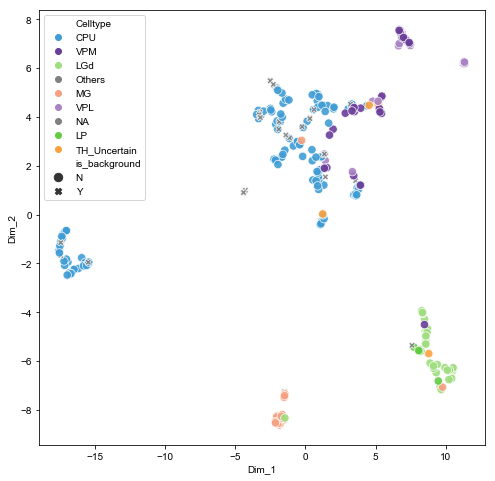

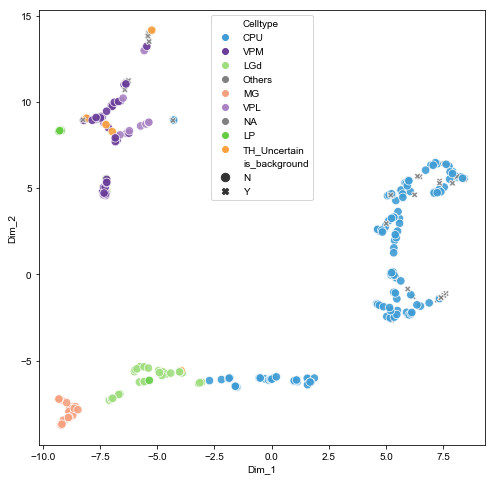

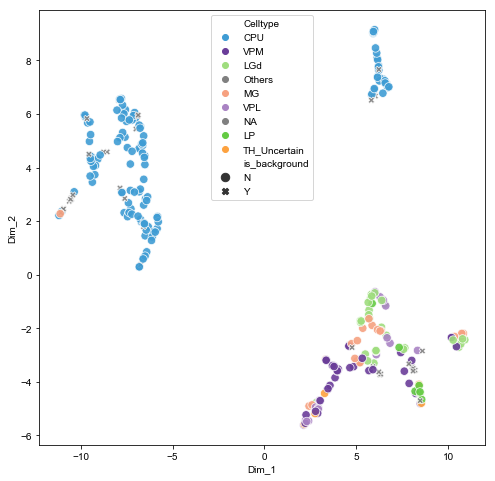

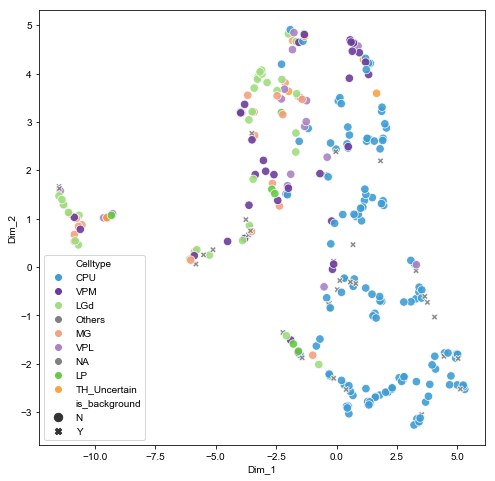

In [8]:
n_neighbors = 5
max_colors = 8

df = UMAP_wrapper(projection_df, n_neighbors=n_neighbors, n_PC=50)
_ = qualitative_scatter(df[0], df[1], metadata[['Celltype']], palette=celltype_color_dict, max_colors=max_colors)

df = UMAP_wrapper(soma_df, n_neighbors=n_neighbors, n_PC=3)
_ = qualitative_scatter(df[0], df[1], metadata[['Celltype']], palette=celltype_color_dict, max_colors=max_colors)

df = UMAP_wrapper(lm_axon_df_scale, n_neighbors=n_neighbors, n_PC=5)
_ = qualitative_scatter(df[0], df[1], metadata[['Celltype']], palette=celltype_color_dict, max_colors=max_colors)

df = UMAP_wrapper(lm_dendrite_df_scale, n_neighbors=n_neighbors, n_PC=5)
_ = qualitative_scatter(df[0], df[1], metadata[['Celltype']], palette=celltype_color_dict, max_colors=max_colors)

## Co-clustering

In [28]:
def get_clusters(inputUMAP,
                 method='SNN_community',
                 karg_dict={'knn':5, 'metric':'minkowski','method':'FastGreedy'}
                ):
    methods_allowed = ['SNN_community', 'Hierarchy', 'Kmeans', 'DBSCAN', 'HDBSCAN']
    assert method in methods_allowed, "Please set 'method' as one of the following: 'SNN_community', 'Hierarchy', 'Kmeans', 'DBSCAN', 'HDBSCAN'"
    selectedUMAP = inputUMAP.copy()
    if method=='SNN_community':
        #print('Result of SNN_community')
        if 'knn' in karg_dict.keys():
            knn = karg_dict['knn']
        else:
            knn = 5
        if 'metric' in karg_dict.keys():
            metric = karg_dict['metric']
        else:
            metric = 'minkowski'
        if 'method' in karg_dict.keys():
            community_method = karg_dict['method']
        else:
            community_method = 'FastGreedy'
        cur_clusters = nmt.get_clusters_SNN_community(selectedUMAP, knn=knn, metric=metric, method=community_method)
        

    #karg_dict={'L_method':'single','L_metric':'euclidean'.'t':0.9,'criterionH':'inconsistent', depth=2, R=None, monocrit=None}
    if method =='Hierarchy':
        #print('Result of Hierarchy CLustering')
        cur_clusters = nmt.get_clusters_Hierarchy_clustering(selectedUMAP, karg_dict)


    if method =='Kmeans':
        #print('Result of Kmeans')
        cur_clusters = nmt.get_clusters_kmeans_clustering(selectedUMAP, karg_dict)

    if method =='DBSCAN':
        #print('Result of DBSCAN')
        cur_clusters = nmt.get_clusters_dbscan_clustering(selectedUMAP, karg_dict)

    if method =='HDBSCAN':
        #print('Result of HDBSCAN')
        cur_clusters = nmt.get_clusters_hdbscan_clustering(selectedUMAP, karg_dict)
    selectedUMAP.loc[:,'Cluster'] = ['C' + str(i) for i in cur_clusters]
    return selectedUMAP

In [48]:
import random
import ast
from scipy.spatial.distance import pdist, squareform
import numpy as np
import matplotlib as mpl
from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import multiprocessing
import time
def fre_Matrix(fre_M, cluster_method,para_test, df_UMAP):
    umapDF = df_UMAP.iloc[random.sample(range(0,df_UMAP.shape[0]), int(df_UMAP.shape[0]*0.95)),:].copy()
    resultDF = get_clusters(umapDF.copy(),method =cluster_method,karg_dict = para_test)
    Crange, Ccounts = np.unique(resultDF["Cluster"], return_counts = True)
    for iter_C in Crange:
        selected_row = resultDF[resultDF["Cluster"]==iter_C]
        Clist = selected_row.index.tolist()
        for sample_row in Clist:
            for sample_col in Clist:
                fre_M.loc[sample_row,sample_col] =  fre_M.loc[sample_row,sample_col]+1
    return fre_M.values

def para_cocluster(cluster_method, para_test, corenum, run_num, df_UMAP):
    start = time.perf_counter ()
    start=time.time()
    cores = corenum#multiprocessing.cpu_count()
#     pool = multiprocessing.Pool(processes=cores)
    pool = multiprocessing.Pool()
    fre_M_t = pd.DataFrame(index = df_UMAP.index, columns = df_UMAP.index)
    fre_M_t [fre_M_t.isnull()]=0
    pool_list=[]
    result_list=[]
    for i in range(run_num):
        pool_list.append(pool.apply_async(fre_Matrix, (fre_M_t, cluster_method, para_test, df_UMAP)))
        # 这里不能 get， 会阻塞进程

    #pool.apply_async之后的语句都是阻塞执行的，
    #调用 result.get() 会等待上一个任务执行完之后才会分配下一个任务。
    #事实上，获取返回值的过程最好放在进程池回收之后进行，避免阻塞后面的语句。
    result_list=[xx.get() for xx in pool_list]
#     print(sum([xx for xx in  result_list]))
    # 最后我们使用一下语句回收进程池:
    pool.close()
    pool.join()
    elapsed = (time.time() - start)
    print('Time needed to run %s is %.2fs' % (cluster_method, elapsed))
    res = pd.DataFrame(sum([xx for xx in  result_list]) / run_num, index=df_UMAP.index, columns=df_UMAP.index)
    return res


# Test
par_snn = {'knn':10,'metric':'minkowski','method':'FastGreedy'}
df = UMAP_wrapper(projection_df, n_neighbors=n_neighbors, n_PC=50)
AP_snn = para_cocluster('SNN_community', par_snn, 20, 20, df)

Time needed to run SNN_community is 14.31s


In [57]:
df = UMAP_wrapper(projection_df, n_neighbors=n_neighbors, n_PC=50)
projection_dist = sklearn.metrics.pairwise.euclidean_distances(df.loc[cell_list])

df = UMAP_wrapper(soma_df, n_neighbors=n_neighbors, PCA_first=False)
soma_dist = sklearn.metrics.pairwise.euclidean_distances(df.loc[cell_list])

df = UMAP_wrapper(lm_axon_df_scale, n_neighbors=n_neighbors, n_PC=5)
axon_dist = sklearn.metrics.pairwise.euclidean_distances(df.loc[cell_list])

df = UMAP_wrapper(lm_dendrite_df_scale, n_neighbors=n_neighbors, n_PC=5)
dendrite_dist = sklearn.metrics.pairwise.euclidean_distances(df.loc[cell_list])


In [75]:
n_neighbors_umap = 10

co_clusters = dict()
k_range = range(3, 11)
round_resample = 1000
# Projection clustering
modality = "projection"
dist = projection_dist
df_umap = UMAP_wrapper(projection_df, n_neighbors=n_neighbors_umap, n_PC=50)
for k in k_range:
    key = "_".join([modality, str(k)])
    print(key)
#     co_cluster = get_co_cluster(dist, cell_list, knn=k,
#                                 ratio_resample=0.95, n_refeature=1000,
#                                 round_resample=round_resample, 
#                                 algorithm='SNN',
#                                 parameter_dict={'metric':'precomputed', 'method':'FastGreedy'}
#                                )
    par_snn = {'knn':k,'metric':'minkowski','method':'FastGreedy'}
    co_cluster = para_cocluster('SNN_community', par_snn, 10, round_resample, df_umap)
    co_clusters[key] = co_cluster
    
# Soma clustering
modality = "soma"
dist = soma_dist
df_umap = UMAP_wrapper(soma_df, n_neighbors=n_neighbors_umap, PCA_first=False)
for k in k_range:
    key = "_".join([modality, str(k)])
    print(key)
#     co_cluster = get_co_cluster(dist, cell_list, knn=k,
#                                 ratio_resample=0.95, n_refeature=1000,
#                                 round_resample=round_resample, 
#                                 algorithm='SNN',
#                                 parameter_dict={'metric':'precomputed', 'method':'FastGreedy'}
#                                )
    par_snn = {'knn':k,'metric':'minkowski','method':'FastGreedy'}
    co_cluster = para_cocluster('SNN_community', par_snn, 10, round_resample, df_umap)
    co_clusters[key] = co_cluster
    
# axon clustering
modality = "axon"
dist = axon_dist
df_umap = UMAP_wrapper(lm_axon_df_scale, n_neighbors=n_neighbors_umap, n_PC=5)
for k in k_range:
    key = "_".join([modality, str(k)])
    print(key)
#     co_cluster = get_co_cluster(dist, cell_list, knn=k,
#                                 ratio_resample=0.95, n_refeature=1000,
#                                 round_resample=round_resample, 
#                                 algorithm='SNN',
#                                 parameter_dict={'metric':'precomputed', 'method':'FastGreedy'}
#                                )
    par_snn = {'knn':k,'metric':'minkowski','method':'FastGreedy'}
    co_cluster = para_cocluster('SNN_community', par_snn, 10, round_resample, df_umap)
    co_clusters[key] = co_cluster
    
# dendrite clustering
modality = "dendrite"
dist = dendrite_dist
df_umap = UMAP_wrapper(lm_dendrite_df_scale, n_neighbors=n_neighbors_umap, n_PC=5)
for k in k_range:
    key = "_".join([modality, str(k)])
    print(key)
#     co_cluster = get_co_cluster(dist, cell_list, knn=k,
#                                 ratio_resample=0.95, n_refeature=1000,
#                                 round_resample=round_resample, 
#                                 algorithm='SNN',
#                                 parameter_dict={'metric':'precomputed', 'method':'FastGreedy'}
#                                )
    par_snn = {'knn':k,'metric':'minkowski','method':'FastGreedy'}
    co_cluster = para_cocluster('SNN_community', par_snn, 10, round_resample, df_umap)
    co_clusters[key] = co_cluster

pickle.dump([co_clusters], open("co_clusters.pickle", "wb"))

projection_3
Time needed to run SNN_community is 251.55s
projection_4
Time needed to run SNN_community is 329.38s
projection_5
Time needed to run SNN_community is 391.69s
projection_6
Time needed to run SNN_community is 478.24s
projection_7
Time needed to run SNN_community is 8946.82s
projection_8
Time needed to run SNN_community is 585.42s
projection_9
Time needed to run SNN_community is 648.09s
projection_10
Time needed to run SNN_community is 807.95s
soma_3
Time needed to run SNN_community is 225.34s
soma_4
Time needed to run SNN_community is 271.67s
soma_5
Time needed to run SNN_community is 351.67s
soma_6
Time needed to run SNN_community is 462.04s
soma_7
Time needed to run SNN_community is 512.94s
soma_8
Time needed to run SNN_community is 586.18s
soma_9
Time needed to run SNN_community is 680.76s
soma_10
Time needed to run SNN_community is 770.21s
axon_3
Time needed to run SNN_community is 218.85s
axon_4
Time needed to run SNN_community is 336.00s
axon_5
Time needed to run SNN_c

In [77]:

# Heatmap
def plot_co_cluster(co_cluster, metadata, thres, save_prefix=None):
    # Plot 1: Hierarchical clustering (by samples)

    Z_sample = linkage(co_cluster, 'ward')
    #     Z_sample = linkage(scipy.spatial.distance.squareform(1-co_cluster), 'ward')

    fig, ax = plt.subplots(1, 1, figsize=(20, 8))
    d = dendrogram(Z_sample, color_threshold=thres,
                   labels=co_cluster.index, leaf_rotation=90, leaf_font_size=2,
                   orientation="top", 
                   no_labels=True
                   )
    plt.axhline(y=thres, c='grey', lw=1, linestyle='dashed')
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('sample index')
    plt.ylabel('distance (Ward)')

#     transforme the 'cyl' column in a categorical variable. It will allow to put one color on each level.
#         my_color=celltype.loc[d['ivl'], 'Sub_type'].cat.codes
    my_color = [celltype_color_dict[metadata.loc[i, "Celltype"]] for i in d['ivl']]  # replace with a new color map, to be implemented
    # Apply the right color to each label
    ax = plt.gca()
    xlbls = ax.get_xmajorticklabels()
    num = -1
    for lbl in xlbls:
        num += 1
        lbl.set_color(my_color[num])
    # if not save_prefix is None:
    #     fig.savefig("../Figure/Dendrogram_AllNeurons_Resample.pdf")

    # Plot 2: Heatmap
    col_colors = pd.DataFrame({'Type': [celltype_color_dict[i] for i in metadata["Celltype"]]},
                              index=metadata.index)
    col_colors = col_colors.loc[co_cluster.index]
    g = sns.clustermap(co_cluster, linecolor='white',
                       row_colors=col_colors, col_colors=col_colors,
                       row_linkage=Z_sample, col_linkage=Z_sample,
                       annot=False, figsize=(12, 12))
    g.savefig("../Figure/Heatmap_CoCluster_AllNeurons.pdf")
    return

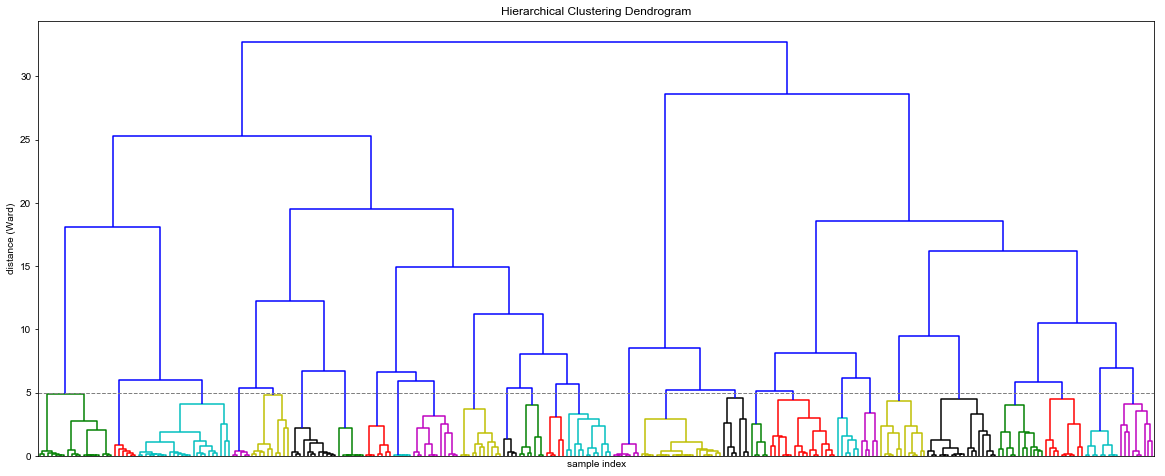

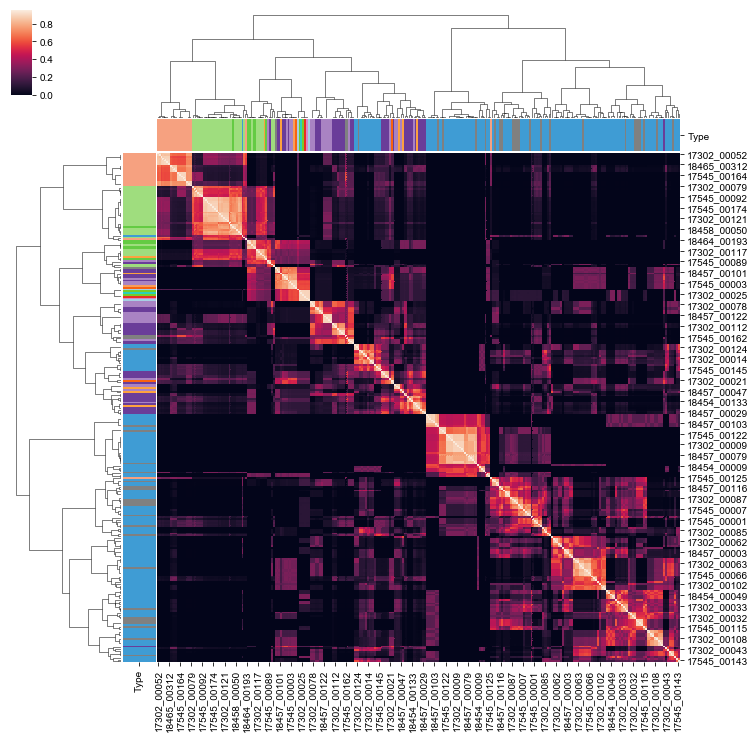

In [267]:
[co_clusters] = pickle.load(open("co_clusters.pickle", 'rb'))

co_cluster = np.zeros([len(cell_list), len(cell_list)])
co_cluster = pd.DataFrame(co_cluster, index=cell_list, columns=cell_list)
use_keys = []
k_range = range(5, 11)
use_keys = ["_".join(["projection", str(i)]) for i in k_range]
use_keys = use_keys + ["_".join(["soma", str(i)]) for i in k_range]
use_keys = use_keys + ["_".join(["axon", str(i)]) for i in k_range]
# use_keys = use_keys + ["_".join(["dendrite", str(i)]) for i in k_range]
weights_dict = dict(zip(use_keys, [1]*len(k_range) + [1]*len(k_range) + [1]*len(k_range) + [1]*len(k_range)))

sum_weights = 0
for key in use_keys:
    sum_weights = sum_weights + weights_dict[key]
    co_cluster = co_cluster + co_clusters[key] * weights_dict[key]

co_cluster = co_cluster/sum_weights

Z_sample = linkage(co_cluster, 'ward')

threshold = 5
plot_co_cluster(co_cluster, metadata, thres=threshold, save_prefix=None)


## Remove outliers

In [197]:
def get_outlier(co_cluster, threshold, min_cluster_size=3, pv_thres=0.1, score_thres=2):

    # 1. Call clusters
    cell_names = co_cluster.index.tolist()
    clusters = get_clusters_SNN_community(co_cluster, knn=8)

#     Z_sample = linkage(co_cluster, 'ward')
#     clusters = fcluster(Z_sample, t=threshold, criterion='distance')

    clusters = pd.DataFrame({"cluster":clusters}, index=cell_names)
    u_clusters = sorted(list(set(clusters.cluster.tolist())))

    # 2. find outliers
    feature_dict = {"Projection":sklearn.metrics.pairwise.euclidean_distances(projection_df.loc[cell_names]),
                    "Soma":sklearn.metrics.pairwise.euclidean_distances(soma_df.loc[cell_names]),
                    "Dendrite":sklearn.metrics.pairwise.euclidean_distances(lm_dendrite_df_scale.loc[cell_names]), 
                    "Axon":sklearn.metrics.pairwise.euclidean_distances(lm_axon_df_scale.loc[cell_names])
                   }
    outlier_df = pd.DataFrame(index=cell_names)
    outlier_df_distance = pd.DataFrame(index=cell_names)

    for k, feature in enumerate(list(feature_dict.keys())):
        dist_df = pd.DataFrame(feature_dict[feature], index=cell_names, columns=cell_names)
        background_dist = []
        for cur_cluster in u_clusters:
            cells_in_cluster = clusters.index[clusters.cluster==cur_cluster]
            dist_in_cluster = np.array(dist_df.loc[cells_in_cluster, cells_in_cluster])
            iu1 = np.triu_indices(len(dist_in_cluster), 1)
            background_dist = background_dist + dist_in_cluster[iu1].tolist()
        pv_list = []
        dist_list = []

        for cell in cell_names:
            cur_cluster = clusters.loc[cell, "cluster"]
            cells_in_cluster = clusters.index[(clusters.cluster==cur_cluster) & (clusters.index!=cell)]
            cells_out_cluster = clusters.index[clusters.cluster!=cur_cluster]            
            if len(cells_in_cluster)<(min_cluster_size-1):
                # Set cell as outlier if cluster is too small
                pv_list.append(pv_thres / 10)
                dist_list.append(1e6)
            else:
#                 dist_in_cluster = dist_df.loc[cell, cells_in_cluster].sort_values()
                dist_in_cluster = dist_df.loc[cell, cells_in_cluster].sort_values()[:min(2, len(cells_in_cluster))]
                dist_out_cluster = np.array(dist_df.loc[cells_out_cluster, cells_out_cluster]).reshape(-1,)
                _, pv = scipy.stats.mannwhitneyu(dist_in_cluster, 
                                                 background_dist,
#                                                  dist_out_cluster,
                                                 alternative='less')
                pv_list.append(pv)
                dist_list.append(np.median(dist_in_cluster))
        outlier_df[feature] = pv_list
        outlier_df_distance[feature] = dist_list
    outlier_df = pd.concat([outlier_df, clusters], axis=1)
    outlier_df_distance = pd.concat([outlier_df_distance, clusters], axis=1)
    
    outlier_df["Score"] = -np.sum(np.log10(outlier_df[list(feature_dict.keys())]), axis=1)
    outlier_cells = outlier_df.index[outlier_df.Score<4].tolist()
#     return outlier_df.loc[outlier_cells].sort_values("cluster"), outlier_df_distance.loc[outlier_cells].sort_values("cluster"), outlier_cells
    return outlier_df.sort_values("cluster"), outlier_df_distance.sort_values("cluster"), outlier_cells


In [12]:
def silhouette_analysis(co_cluster, df=None, plot=False):
    dist_co_cluster = np.array(1 - co_cluster)
    Z_sample = linkage(co_cluster, "ward")
    cur_nclusters = 0
    score_list = []
    thres_list = []
    for thres_test in np.linspace(0.5, 8, 200).tolist():
        clusters = fcluster(Z_sample, t=thres_test, criterion='distance')
        silhouette_avg_1 = silhouette_score(dist_co_cluster, metric='precomputed', labels=clusters)
#         silhouette_avg_2 = silhouette_score(df, metric='euclidean', labels=clusters)
        nclusters = len(list(set(clusters.tolist())))
        if cur_nclusters != nclusters:
            score_list.append(silhouette_avg_1)
            thres_list.append(thres_test)
#             print("Threshold = %0.2f" % thres_test,
#                   "N clusters = %d" % nclusters,
#                   "Average silhouette_score = %0.2f; %0.2f" % (silhouette_avg_1, silhouette_avg_2)
#                  )
        cur_nclusters = nclusters
    if plot:
        plt.bar(thres_list, score_list, 0.1)
        plt.bar(thres_list[np.argmax(score_list)], score_list[np.argmax(score_list)], 0.1, color="red")
    return thres_list[np.argmax(score_list)]


In [268]:
cur_cell_list = co_cluster.index.tolist()
cell_names = co_cluster.index.to_list()
threshold = 5
for iteration in range(1, 10):
    threshold = silhouette_analysis(co_cluster.loc[cur_cell_list, cur_cell_list])
#     threshold = threshold
    outlier_df, outlier_df_distance, cur_outlier_list = get_outlier(co_cluster.loc[cur_cell_list], 
                                                                    threshold, 
                                                                    pv_thres=5
                                                                   )
    print("Round %d: %d outliers; threshold=%.2e" % (iteration, len(cur_outlier_list), threshold))
    if len(cur_outlier_list)==0:
        break
    cur_cell_list = [j for j in cur_cell_list if not j in cur_outlier_list]

selected_cells = cur_cell_list
outlier_cells = [i for i in cell_names if not i in selected_cells]
print("Total outliers: %d" % len(outlier_cells))

print(metadata.loc[outlier_cells, "Celltype"].value_counts())

Round 1: 33 outliers; threshold=2.01e+00
Round 2: 7 outliers; threshold=1.93e+00
Round 3: 2 outliers; threshold=1.82e+00
Round 4: 1 outliers; threshold=1.82e+00
Round 5: 0 outliers; threshold=1.82e+00
Total outliers: 43
Others          8
CPU             7
LGd             6
VPM             5
LP              5
MG              2
MD              2
TH_Uncertain    2
VPL             2
PO              1
VAL             1
IMD             1
AM              1
Name: Celltype, dtype: int64


## Get final clusters

In [291]:
co_cluster_selected = co_cluster.loc[selected_cells, selected_cells]
clusters = get_clusters_SNN_community(co_cluster_selected, knn=8)
clusters = pd.DataFrame({"cluster":clusters}, index=selected_cells)
u_clusters = sorted(list(set(clusters.cluster.tolist())))
print('number of clusters %d' % len(u_clusters))

metadata['cluster'] = 'NA'
metadata.loc[clusters.index, 'cluster'] = ["C"+str(i) for i in clusters.loc[clusters.index, 'cluster'].tolist()]

bupu = cl.scales['9']['seq']['BuPu']
greens = cl.scales['9']['seq']['Greens']
set2 = cl.scales['7']['qual']['Set2']
spectral = cl.scales['9']['div']['Spectral']
paired = cl.scales['10']['qual']['Paired']

def rgb_to_list(rgb_str):
    tp = rgb_str.replace("rgb(", "").replace("rgba(", "").replace(")", "")
    res = [float(i)/255 for i in tp.split(", ")]
    return res

def get_feature_colors(metadata, feature, palette=paired):
    u_features = sorted(list(set(metadata[feature])))
    color_list = cl.to_rgb(cl.interp(paired, len(u_features)))
    color_list = [rgb_to_list(i) for i in color_list]
    feature_colors = dict(zip(u_features, color_list))
    if "Others" in u_features:
        feature_colors["Others"] = rgb_to_list('rgb(128, 128, 128)')
    return feature_colors

cluster_color_dict = get_feature_colors(metadata, 'cluster')
brain_color_dict = get_feature_colors(metadata, 'Brain_id')


number of clusters 9


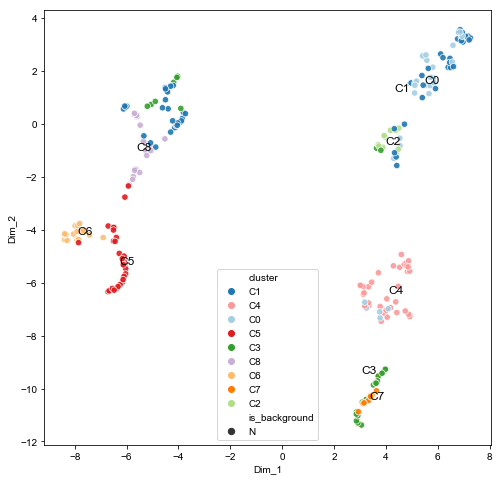

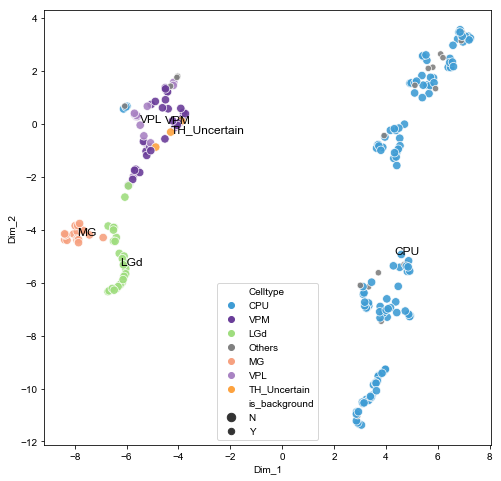

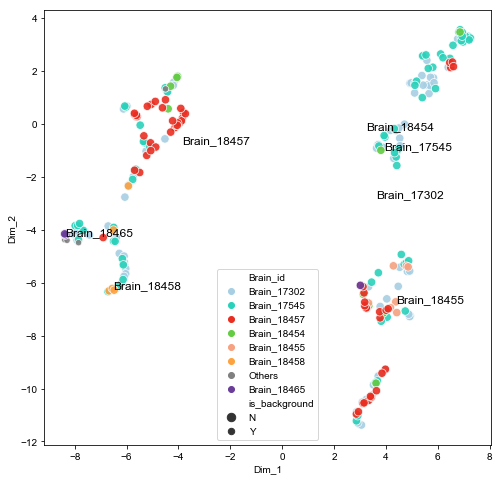

In [292]:
def cluster_scatter(x, y, c, palette='Spectral', max_colors=10):
    max_col = 3
    subplot_w = 8
    subplot_h = 8
    feature_list = c.columns.tolist()
    subplot_n = len(feature_list)
    if subplot_n <= max_col:
        n_col = subplot_n
        n_row = 1
    else:
        n_col = max_col
        n_row = int(subplot_n / max_col)
        if (subplot_n % max_col) != 0:
            n_row += 1
    fig, ax = plt.subplots(n_row, n_col,
                           figsize=(subplot_w * n_col,
                                    subplot_h * n_row),
                           squeeze=False
                           )
    ax = ax.reshape(-1)
    df = pd.DataFrame({'Dim_1': x, 'Dim_2': y})
    df = pd.concat([df, c.copy()], axis=1)
    df['is_background'] = 'N'
    for i, cur_ax in enumerate(ax.tolist()[:subplot_n]):
        feature_name = feature_list[i]
        ct = df[feature_name].value_counts()
        # Control length of legend
        if len(ct) > max_colors:
            collapsed_features = ct[max_colors:].index.tolist() + ['unknown', "fiber tracts"]
            df.loc[df[feature_name].isin(collapsed_features), feature_name] = "Others"
            df.loc[df[feature_name].isin(["Others", "NA"]), "is_background"] = "Y"

        # background color
        if type(palette) == dict:
            palette['Others'] = (.5, .5, .5)
            palette['NA'] = (.5, .5, .5)

        ct = df[feature_name].value_counts()
        hue_order = ct.index.tolist()
        sns.scatterplot(x='Dim_1', y='Dim_2',
                        hue=feature_name,
                        hue_order = hue_order,
                        data=df,
                        palette=palette,
                        alpha=0.9,
                        size="is_background",
                        sizes=(41, 71),
#                         style="is_background",
                        ax=cur_ax,
#                         legend=False
                       )
        # Label clusters
        u_features = list(set(df[feature_name].tolist()))
#         print(df[feature_name].value_counts())
#         print(u_features)
        for cur_feature in u_features:
            if cur_feature in ['Others', 'NA', "unknown", np.nan]:
                continue
            cur_x = np.median(x.loc[df[feature_name] == cur_feature])
            cur_y = np.median(y.loc[df[feature_name] == cur_feature])
            cur_ax.text(cur_x, cur_y, str(cur_feature), fontdict={"size":12})
    return fig



# pca_soma = PCA_wrapper(soma_df.loc[selected_cells], n_components=3)
pca_soma = soma_df.loc[selected_cells]
pca_projection = PCA_wrapper(projection_df.loc[selected_cells], n_components=50)
pca_axon = PCA_wrapper(lm_axon_df_scale.loc[selected_cells], n_components=5)
df_umap_input = pd.concat([pca_soma, pca_projection, pca_axon], axis=1)

n_neighbors = 8
df = UMAP_wrapper(df_umap_input, n_neighbors=n_neighbors, n_PC=50)

_ = cluster_scatter(df[0], df[1], 
                        metadata.loc[selected_cells, ['cluster']], 
                        palette=cluster_color_dict,
                        max_colors=20)

_ = cluster_scatter(df[0], df[1], 
                        metadata.loc[selected_cells, ['Celltype']], 
                        palette=celltype_color_dict,
                        max_colors=7)

_ = cluster_scatter(df[0], df[1], 
                        metadata.loc[selected_cells, ['Brain_id']], 
                        palette=brain_color_dict,
                        max_colors=7)

## Feature heatmap

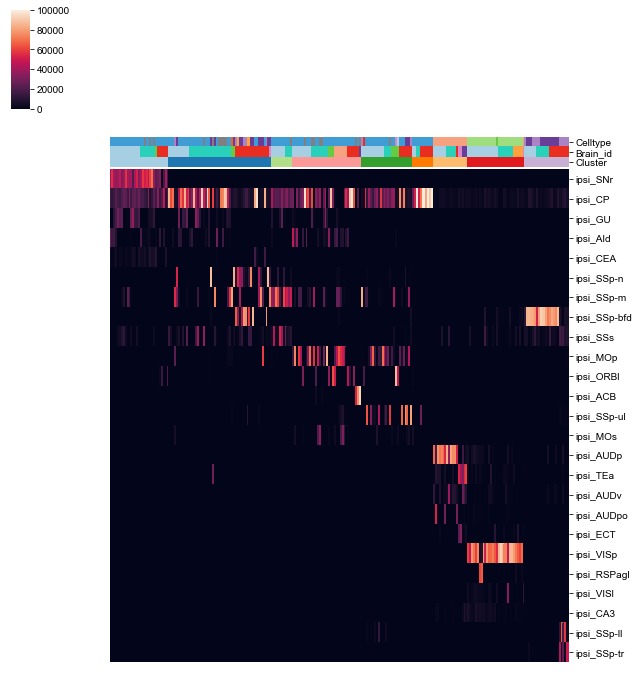

In [348]:
cell_list = metadata.loc[selected_cells].sort_values('cluster').index.tolist()
cluster_list = [0, 1, 2,4,3,7,6,5,8
               ]
cluster_list = ["C"+str(i) for i in cluster_list]
cell_list = []
for i in cluster_list:
    cell_list = cell_list + metadata[metadata.cluster == i].index.tolist()
    
# df_feature = projection_df.copy().loc[cell_list]
df_feature = np.exp(projection.scaled_data.copy().loc[cell_list]) - 100
df_feature.drop(columns=["ipsi_fiber tracts"], inplace=True)
df_heatmap = pd.DataFrame(index=cell_list)

used_regions = []
for cur_cluster in cluster_list:
    cur_list = metadata[metadata.cluster == cur_cluster].index.tolist()
    tp = df_feature.loc[cur_list]
#     tp = np.sum(tp, axis=0).sort_values(ascending=False).index.tolist()[:3]
    tp = np.sum(tp, axis=0).sort_values(ascending=False).index.tolist()[:5]
    tp = [i for i in tp if not i in used_regions]
    used_regions = used_regions + tp
    
df_heatmap = df_feature[used_regions]


# col_colors = [cluster_color_dict[metadata.loc[i, 'cluster']] for i in cell_list]
celltype_colors = [celltype_color_dict[metadata.loc[i, 'Celltype']] for i in cell_list]
brain_colors = [brain_color_dict[metadata.loc[i, 'Brain_id']] for i in cell_list]
cluster_colors = [cluster_color_dict[metadata.loc[i, 'cluster']] for i in cell_list]
col_colors = pd.DataFrame({"Celltype": celltype_colors,
                           "Brain_id": brain_colors,
                           "Cluster": cluster_colors
                          }, 
                          index=cell_list)
g = sns.clustermap(df_heatmap.transpose(), linecolor='white',
#                    vmin=0, vmax=np.max(np.array(co_cluster)),
#                    col_colors=row_colors, 
                   col_colors=col_colors,
#                    row_linkage=Z_sample, col_linkage=Z_sample,
                   row_cluster=False, col_cluster=False,
                   yticklabels=True, xticklabels=False,
                   annot=False, figsize=(10, 12))

In [334]:
def diff_features(df_feature, metadata, group_by, group_1, group_2, show_heatmap=True):
    feature_list = df_feature.columns.tolist()
    pv_list = [1]*len(feature_list)
    fc_list = [0]*len(feature_list)
    list_1 = metadata[metadata[group_by]==group_1].index.tolist()
    list_2 = metadata[metadata[group_by]==group_2].index.tolist()
    assert len(list_1)>=3, "group_1 does not have enough members"
    assert len(list_2)>=3, "group_2 does not have enough members"
    df_1 = df_feature.loc[list_1]
    df_2 = df_feature.loc[list_2]
    for i, cur_feature in enumerate(feature_list):
#         print(cur_feature)
#         return df_1[cur_feature], df_2[cur_feature]
#         print(np.var(df_1[cur_feature]), np.var(df_2[cur_feature]))
        if ((np.var(df_1[cur_feature])==0) & (np.var(df_2[cur_feature])==0)):
            continue
        _, pv_list[i] = scipy.stats.mannwhitneyu(df_1[cur_feature], df_2[cur_feature])
#         fc_list[i] = np.log2((np.mean(df_1[cur_feature])+1) / (np.mean(df_2[cur_feature])))
    res = pd.DataFrame({'P-value':pv_list, 
#                         'log2(Fold_change)':fc_list
                       }, 
                       index=feature_list).sort_values('P-value')
    if show_heatmap:
        diff_list = res[res["P-value"]<0.01].index.tolist()
        celltype_colors = [celltype_color_dict[metadata.loc[i, 'Celltype']] for i in compare_list]
        brain_colors = [brain_color_dict[metadata.loc[i, 'Brain_id']] for i in compare_list]
        cluster_colors = [cluster_color_dict[metadata.loc[i, 'cluster']] for i in compare_list]
        col_colors = pd.DataFrame({"Celltype": celltype_colors,
                                   "Brain_id": brain_colors,
                                   "Cluster": cluster_colors
                                  }, 
                                  index=compare_list)
        g = sns.clustermap(df_feature.loc[compare_list, diff_list].transpose(), linecolor='white',
                           col_colors=col_colors,
                           row_cluster=False, col_cluster=False,
                           yticklabels=True, xticklabels=False,
                           annot=False, figsize=(10, 12))
    return res.loc[diff_list], list_1+list_2



In [319]:
th_list = metadata[~metadata.Celltype.isin(["CPU", "Others"])].index.tolist()
th_metadata = metadata.loc[th_list].copy()

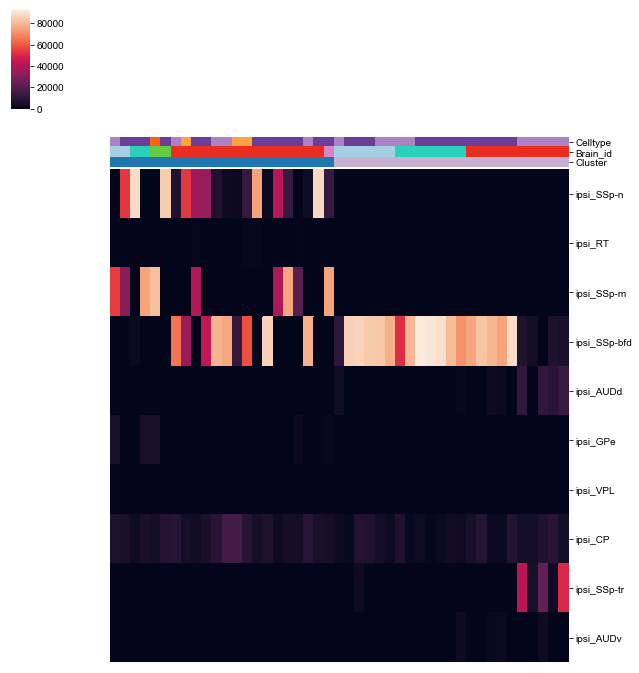

In [343]:
df_feature = np.exp(projection.scaled_data.copy().loc[cell_list]) - 100
df_feature = df_feature.round(2)
df_feature.drop(columns=["ipsi_fiber tracts"], inplace=True)

tp, compare_list = diff_features(df_feature, th_metadata, 'cluster', 'C1', 'C8')

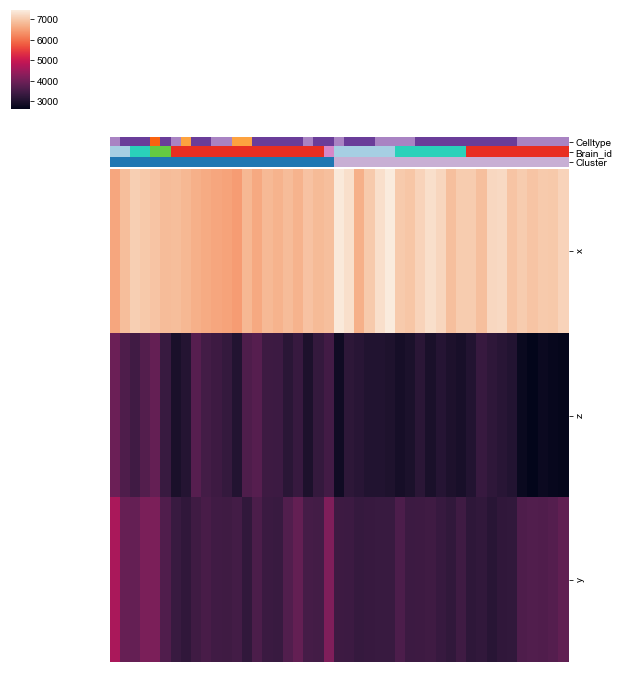

In [328]:
df_feature = soma_df.copy()

tp, compare_list = diff_features(df_feature, th_metadata, 'cluster', 'C1', 'C8')

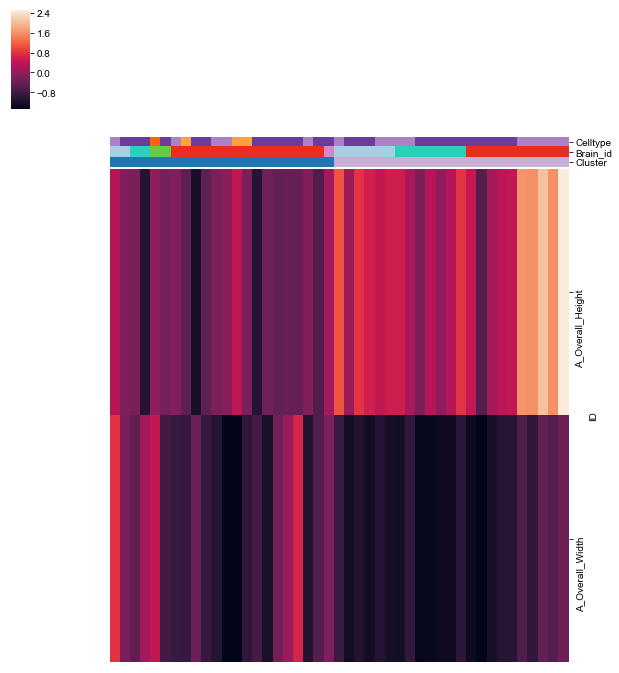

In [329]:
tp, compare_list = diff_features(lm_axon_df_scale, th_metadata, 'cluster', 'C1', 'C8')

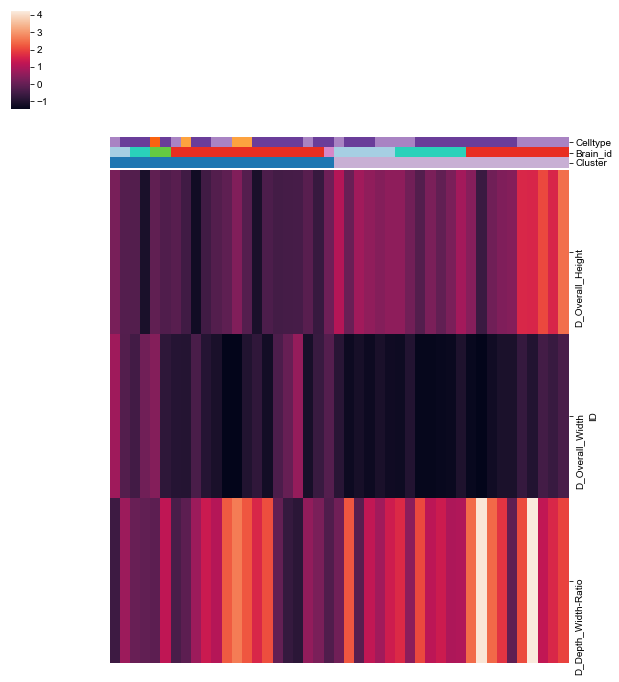

In [332]:
tp, compare_list = diff_features(lm_dendrite_df_scale, th_metadata, 'cluster', 'C1', 'C8')